## Load Packages

In [1]:
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append("..")

import sys 

import subprocess 

import os
import numpy as np
from importlib import reload 
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import networkx as nx 
from tqdm import tqdm

import torch
import torch_geometric as geonn
from torch_geometric.loader import DataListLoader
from torch_geometric.nn import DataParallel


from utilities import solver
from utilities import utils 
from utilities import reader
from utilities import vis

import model_dss as dss
import model_dsgps as dsgps
import model_psignn as psignn

from importlib import reload

from special_geo import mesh_circle_config as mesh_circle 
# from special_geo import mesh_square
from special_geo import spec_geo as spc
# from special_geo import mesh_2d

Random seed set as 1234


In [2]:
from importlib import reload 
reload(mesh_circle)

RR = 1

# config = {  "path_mesh"     : "special_geo/mesh_files/",
#             "name_mesh"     : "square",
#             "width"         : RR,
#             "height"        : RR,
#             "hsize"         : 0.08,
#             "tag_dirichlet" : 101,
#             "view"          : True
#             }
# mesh_circle.build_mesh(config)

config = {  "path_mesh"     : "special_geo/mesh_files/",
            "name_mesh"     : "circle",
            "radius"        : 1.0,
            "hsize"         : 0.08,
            "tag_dirichlet" : 101,
            "view"          : True
            }
mesh_circle.build_mesh(config)

reload(spc)
data_psignn, data_dss = spc.build_data("special_geo/mesh_files/circle", RR)
print(data_psignn)
print(data_dss)

dictpos = {}
for i in range(len(data_psignn.pos)):
    dictpos[i] = np.asarray([data_psignn.pos[i,0].item(), data_psignn.pos[i,1].item()])

net_data = geonn.utils.to_networkx(data_psignn, to_undirected = False, remove_self_loops=False)
G = net_data.to_undirected()
G.remove_edges_from(nx.selfloop_edges(G))
G.remove_nodes_from(list(nx.isolates(G)))
d = nx.distance_measures.diameter(G)
print("Diameter : ", d)

hsize :  0.08
Radius :  1.0
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Circle)
Info    : [ 40%] Meshing curve 2 (Circle)
Info    : [ 70%] Meshing curve 3 (Circle)
Info    : Done meshing 1D (Wall 0.000470261s, CPU 0.000393s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0188397s, CPU 0.013916s)
Info    : 664 nodes 1328 elements
Info    : Writing 'special_geo/mesh_files/circle/mesh.msh'...
Info    : Done writing 'special_geo/mesh_files/circle/mesh.msh'
Data(x=[663, 1], edge_index=[2, 4147], edge_attr=[4147, 3], y=[663, 1], pos=[663, 2], a_ij=[4147, 1], sol=[663, 1], prb_data=[663, 2], tags=[663, 1])
Data(x=[663, 1], edge_index=[2, 3484], edge_attr=[3484, 1], pos=[663, 2], edge_attr_norm=[3484, 1], b_prime=[663, 3], b_prime_norm=[663, 3], tags=[663, 1], sol=[663, 1])
Diameter :  30


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

ckpt_best_dss = torch.load("results_dss/ckpt/best_model.pt")
ckpt_best_dsgps = torch.load("results_dsgps/ckpt/best_model.pt")
ckpt_best_psignn = torch.load("results_psignn/ckpt/best_model.pt")

In [8]:
reload(spc)
reload(vis)
reload(psignn)

spc.test_sample([ckpt_best_dss, ckpt_best_dsgps, ckpt_best_psignn], [data_dss, data_psignn], device)

Random seed set as 1234
Results for Deep Statistical Solvers
┍━━━━━━━━━━━━┯━━━━━━━━━━━━┯━━━━━━━━━━━┯━━━━━━━━━━━━━━━━┑
│   Nb nodes │   Residual │       MSE │   MSEDirichlet │
┝━━━━━━━━━━━━┿━━━━━━━━━━━━┿━━━━━━━━━━━┿━━━━━━━━━━━━━━━━┥
│        663 │  1.080e-03 │ 9.824e-01 │      3.418e-04 │
┕━━━━━━━━━━━━┷━━━━━━━━━━━━┷━━━━━━━━━━━┷━━━━━━━━━━━━━━━━┙
Results for DSGPS
┍━━━━━━━━━━━━┯━━━━━━━━━━━━┯━━━━━━━━━━━┯━━━━━━━━━━━━━━━━┑
│   Nb nodes │   Residual │       MSE │   MSEDirichlet │
┝━━━━━━━━━━━━┿━━━━━━━━━━━━┿━━━━━━━━━━━┿━━━━━━━━━━━━━━━━┥
│        663 │  2.490e-03 │ 1.218e-01 │      1.469e-05 │
┕━━━━━━━━━━━━┷━━━━━━━━━━━━┷━━━━━━━━━━━┷━━━━━━━━━━━━━━━━┙
Results for PSIGNN
┍━━━━━━━━━━━━┯━━━━━━━━━━━━┯━━━━━━━━━━━┯━━━━━━━━━━━━━━━━┯━━━━━━━━━┑
│   Nb nodes │   Residual │       MSE │   MSEDirichlet │   Nstep │
┝━━━━━━━━━━━━┿━━━━━━━━━━━━┿━━━━━━━━━━━┿━━━━━━━━━━━━━━━━┿━━━━━━━━━┥
│        663 │  2.888e-03 │ 5.677e-03 │      2.998e-05 │     103 │
┕━━━━━━━━━━━━┷━━━━━━━━━━━━┷━━━━━━━━━━━┷━━━━━━━━━━━━━━━━┷━━━━━━━━

(0.9823799133300781, 0.12178962677717209, 2.9984183129272424e-05, 103)

In [15]:
from importlib import reload 

reload(mesh_circle)

config = {  "path_mesh"     : "special_geo/mesh_files/",
            "name_mesh"     : "circlelarge",
            "radius"        : 3.0,
            "hsize"         : 0.08,
            "tag_dirichlet" : 101,
            "view"          : True
            }

mesh_circle.build_mesh(config)

reload(spc)

data_psignn, data_dss = spc.build_data("special_geo/mesh_files/circlelarge", 3)
print(data_psignn)
print(data_dss)

hsize :  0.08
Radius :  3.0
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Circle)
Info    : [ 40%] Meshing curve 2 (Circle)
Info    : [ 70%] Meshing curve 3 (Circle)
Info    : Done meshing 1D (Wall 0.000614899s, CPU 0.000616s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.181556s, CPU 0.18161s)
Info    : 5330 nodes 10660 elements
Info    : Writing 'special_geo/mesh_files/circlelarge/mesh.msh'...
Info    : Done writing 'special_geo/mesh_files/circlelarge/mesh.msh'
Data(x=[5329, 1], edge_index=[2, 35874], edge_attr=[35874, 3], y=[5329, 1], pos=[5329, 2], a_ij=[35874, 1], sol=[5329, 1], prb_data=[5329, 2], tags=[5329, 1])
Data(x=[5329, 1], edge_index=[2, 30545], edge_attr=[30545, 1], pos=[5329, 2], edge_attr_norm=[30545, 1], b_prime=[5329, 3], b_prime_norm=[5329, 3], tags=[5329, 1], sol=[5329, 1])


In [16]:
reload(spc)

reload(vis)

mse_psignn, mse_dss = spc.test_sample([ckpt_best_psignn, ckpt_best_dss], [data_psignn, data_dss], device)

┍━━━━━━━━━━━━┯━━━━━━━━━━━━┯━━━━━━━━━━━┯━━━━━━━━━━━━━━━━┯━━━━━━━━━┑
│   Nb nodes │   Residual │       MSE │   MSEDirichlet │   Nstep │
┝━━━━━━━━━━━━┿━━━━━━━━━━━━┿━━━━━━━━━━━┿━━━━━━━━━━━━━━━━┿━━━━━━━━━┥
│       5329 │  1.117e-03 │ 2.173e+00 │      2.507e-05 │     231 │
┕━━━━━━━━━━━━┷━━━━━━━━━━━━┷━━━━━━━━━━━┷━━━━━━━━━━━━━━━━┷━━━━━━━━━┙
┍━━━━━━━━━━━━┯━━━━━━━━━━━━┯━━━━━━━━━━━┯━━━━━━━━━━━━━━━━┑
│   Nb nodes │   Residual │       MSE │   MSEDirichlet │
┝━━━━━━━━━━━━┿━━━━━━━━━━━━┿━━━━━━━━━━━┿━━━━━━━━━━━━━━━━┥
│       5329 │  7.150e-04 │ 4.873e+00 │      3.348e-04 │
┕━━━━━━━━━━━━┷━━━━━━━━━━━━┷━━━━━━━━━━━┷━━━━━━━━━━━━━━━━┙


In [11]:
from special_geo import mesh_square_config as mesh_square
reload(spc)
reload(vis)
reload(mesh_square)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

width = [0.5, 1.0, 2.0, 4.0, 5.0, 7.0]

ckpt_best_dss = torch.load("results_dss/ckpt/best_model.pt")
ckpt_best_dsgps = torch.load("results_dsgps/ckpt/best_model.pt")
ckpt_best_psignn = torch.load("results_psignn/ckpt/best_model.pt")

dssval, dsgpsval, psignnval = [], [], []
nnodes, psignn_nnsteps = [], []
dss_clock, dsgps_clock, psignn_clock = [], [], []

for i in width:
    
    torch.cuda.empty_cache()
    
    config = {  "path_mesh"     : "special_geo/mesh_files/",
                "name_mesh"     : "square",
                "width"         : i,
                "height"        : i,
                "hsize"         : 0.08,
                "tag_dirichlet" : 101,
                "view"          : True
            }
    
    nb_nodes = mesh_square.build_mesh(config)
    nnodes.append(nb_nodes)
    
    data_psignn, data_dss = spc.build_data("special_geo/mesh_files/square", i)

    print(data_psignn)
    print(data_dss)
    
    mse_dss, mse_dsgps, mse_psignn, nsteps_psignn, dss_time, dsgps_time, psignn_time = spc.test_sample([ckpt_best_dss, ckpt_best_dsgps, ckpt_best_psignn], [data_dss, data_psignn], device)
    
    dssval.append(mse_dss)
    dsgpsval.append(mse_dsgps)
    psignnval.append(mse_psignn)
    psignn_nnsteps.append(nsteps_psignn)
    dss_clock.append(dss_time)
    dsgps_clock.append(dsgps_time)
    psignn_clock.append(psignn_time)
    
    torch.cuda.empty_cache()

hsize :  0.08
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 50%] Meshing curve 3 (Line)
Info    : [ 80%] Meshing curve 4 (Line)
Info    : Done meshing 1D (Wall 0.0002209s, CPU 0.000358s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.00145565s, CPU 0.001365s)
Info    : 75 nodes 152 elements
Info    : Writing 'special_geo/mesh_files/square/mesh.msh'...
Info    : Done writing 'special_geo/mesh_files/square/mesh.msh'
Data(x=[75, 1], edge_index=[2, 355], edge_attr=[355, 3], y=[75, 1], pos=[75, 2], a_ij=[355, 1], sol=[75, 1], prb_data=[75, 2], tags=[75, 1])
Data(x=[75, 1], edge_index=[2, 280], edge_attr=[280, 1], pos=[75, 2], edge_attr_norm=[280, 1], b_prime=[75, 3], b_prime_norm=[75, 3], tags=[75, 1], sol=[75, 1])
Results for Deep Statistical Solvers
┍━━━━━━━━━━━━┯━━━━━━━━━━━━┯━━━━━━━━━━━┯━━━━━━━━━━━━━━━━┑
│   Nb nodes │   Residual │       MSE │   MSEDirich

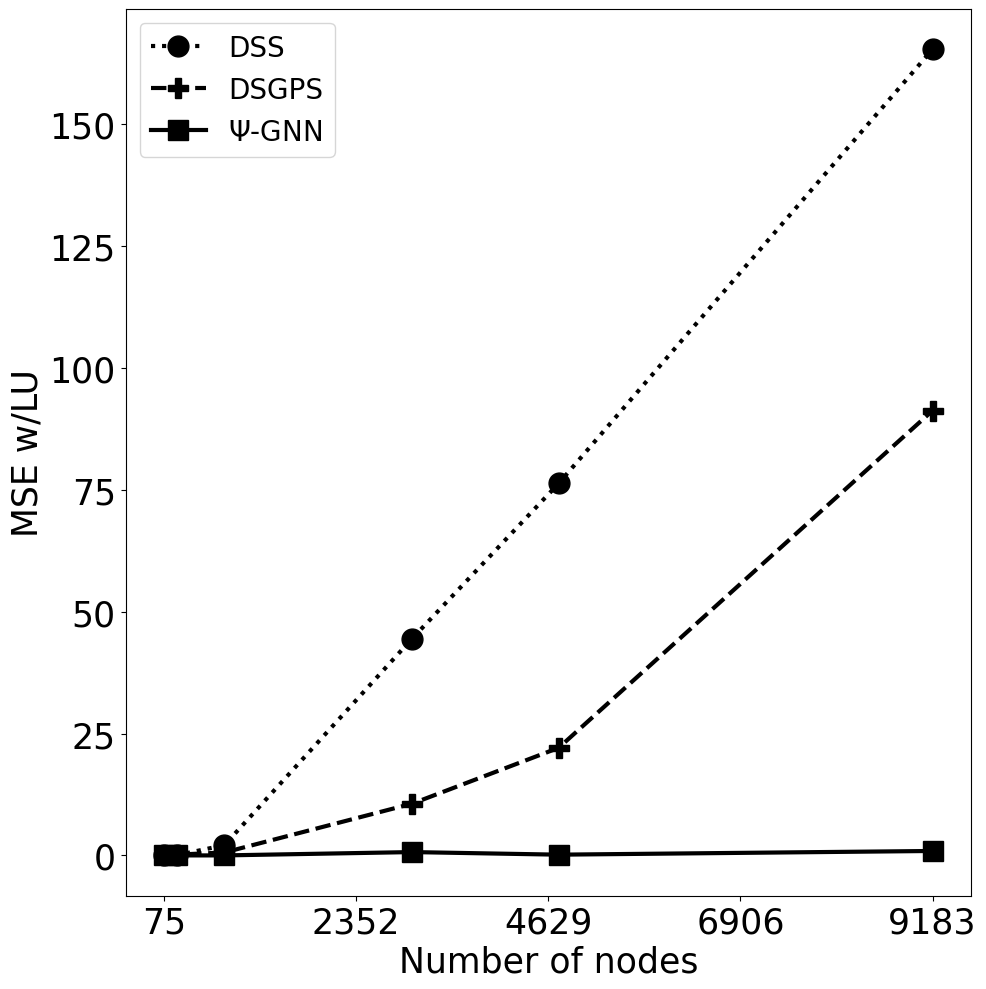

In [12]:
plt.figure(figsize = [10,10])
plt.plot(nnodes, dssval, color='black', marker = 'o', linestyle = 'dotted', markersize = 15, linewidth = 3, label = "DSS")
plt.plot(nnodes, dsgpsval, color='black', marker = 'P', linestyle = 'dashed', markersize = 15, linewidth = 3, label = "DSGPS")
plt.plot(nnodes, psignnval, color='black', marker = 's', linestyle = 'solid', markersize = 15, linewidth = 3, label = "$\Psi$-GNN")
plt.legend(fontsize=20)
plt.xlabel("Number of nodes", fontsize = 25)
plt.ylabel("MSE w/LU", fontsize = 25)
plt.xticks(np.linspace(nnodes[0], nnodes[-1], 5, dtype = 'int'), fontsize = 25)
plt.yticks(fontsize = 25)
# plt.yscale("log")
plt.tight_layout()
plt.savefig("img/growing_geometry_comparative.png", dpi = 500, transparent = True)

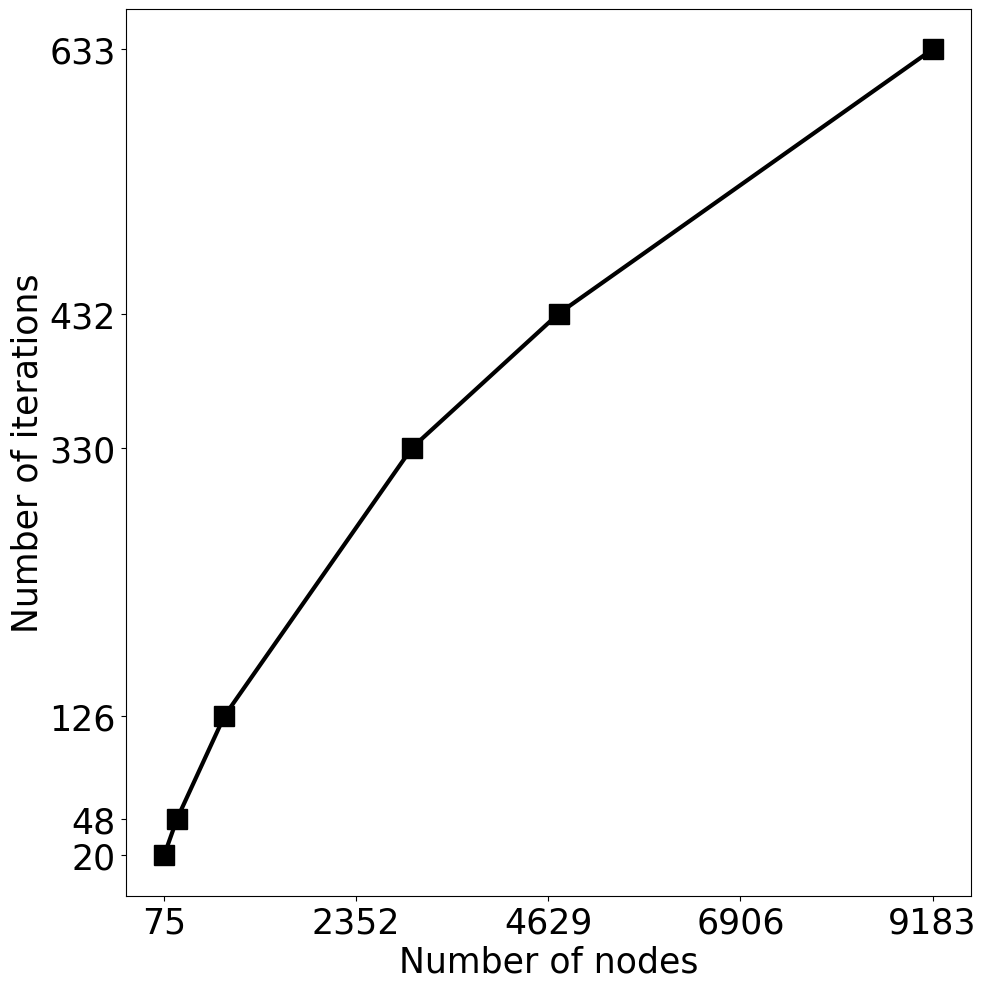

In [13]:
plt.figure(figsize = [10,10])
plt.plot(nnodes, psignn_nnsteps, color = 'black', marker = 's', linestyle = "solid", markersize = 15, linewidth = 3)
plt.xlabel("Number of nodes", fontsize = 25)
plt.ylabel("Number of iterations", fontsize = 25)
plt.xticks(np.linspace(nnodes[0], nnodes[-1], 5, dtype = 'int'), fontsize = 25)
plt.yticks(psignn_nnsteps, fontsize = 25)
plt.tight_layout()
plt.savefig("img/growing_geometry_number_of_iterations.png", dpi = 500, transparent = True)

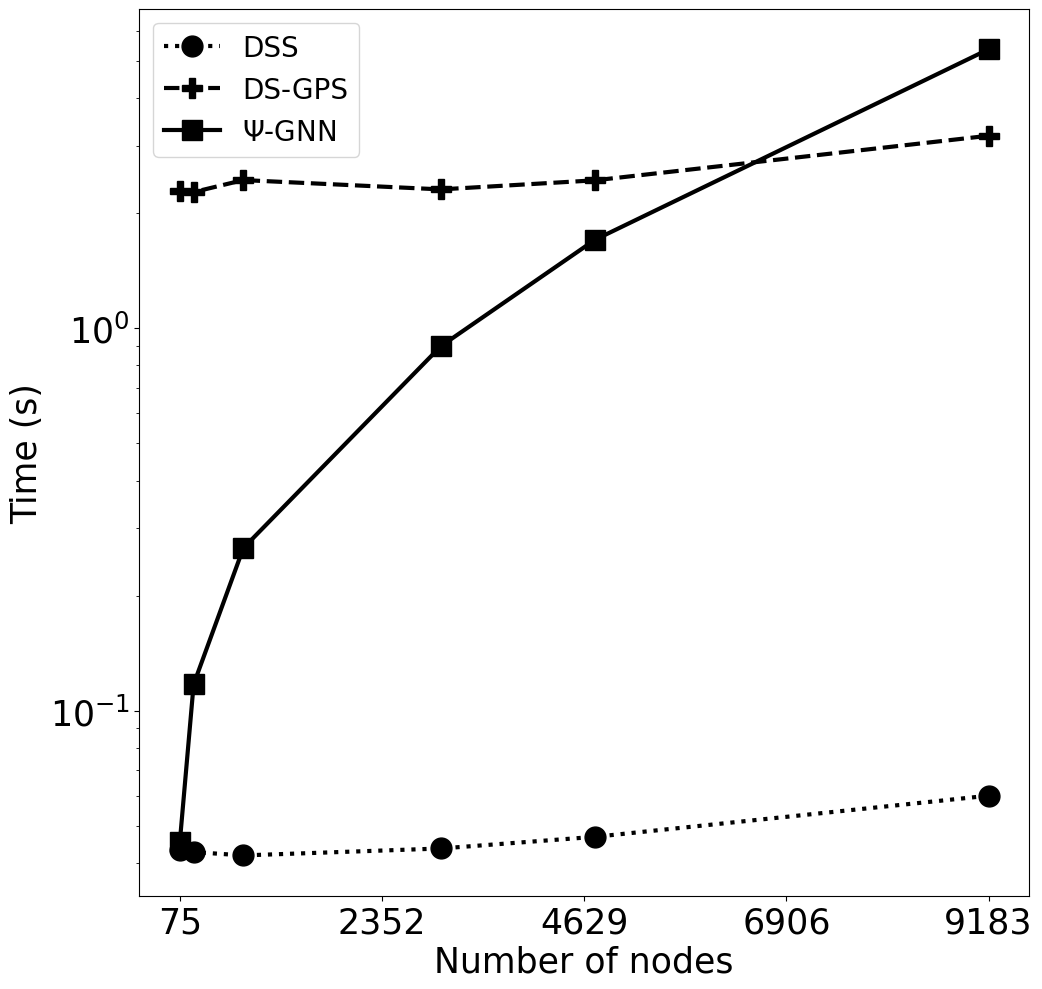

In [16]:
plt.figure(figsize = [10,10])
plt.plot(nnodes, dss_clock, color = 'black', marker = 'o', linestyle = "dotted", markersize = 15, linewidth = 3, label = "DSS")
plt.plot(nnodes, dsgps_clock, color = 'black', marker = 'P', linestyle = "dashed", markersize = 15, linewidth = 3, label = "DS-GPS")
plt.plot(nnodes, psignn_clock, color = 'black', marker = 's', linestyle = "solid", markersize = 15, linewidth = 3, label = '$\Psi$-GNN')
plt.xlabel("Number of nodes", fontsize = 25)
plt.ylabel("Time (s)", fontsize = 25)
plt.legend(fontsize=20)
plt.xticks(np.linspace(nnodes[0], nnodes[-1], 5, dtype = 'int'), fontsize = 25)
plt.yticks(fontsize = 25)
plt.tight_layout()
plt.yscale('log')
plt.savefig("img/time_inference.png", dpi = 500, transparent = True)

hsize :  0.08
Info    : Meshing 1D...
Info    : Meshing curve 1 (Nurb)
Info    : Done meshing 1D (Wall 0.00904074s, CPU 0.009063s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0126703s, CPU 0.012912s)
Info    : 495 nodes 981 elements
Info    : Writing 'special_geo/mesh_files/original/mesh.msh'...
Info    : Done writing 'special_geo/mesh_files/original/mesh.msh'
Data(x=[487, 1], edge_index=[2, 2983], edge_attr=[2983, 3], y=[487, 1], pos=[487, 2], a_ij=[2983, 1], sol=[487, 1], prb_data=[487, 2], tags=[487, 1])
Data(x=[487, 1], edge_index=[2, 2496], edge_attr=[2496, 1], pos=[487, 2], edge_attr_norm=[2496, 1], b_prime=[487, 3], b_prime_norm=[487, 3], tags=[487, 1], sol=[487, 1])
cuda:0
cuda:0
cuda:0


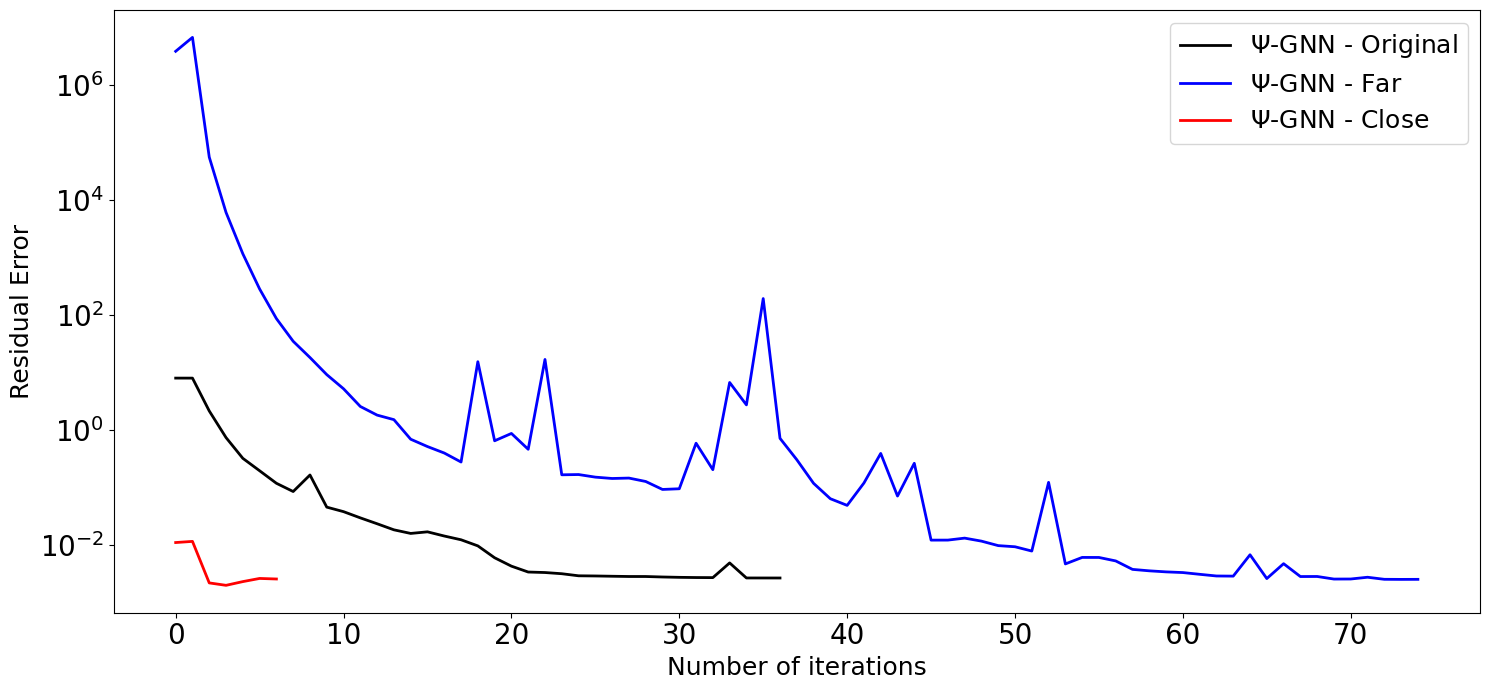

In [126]:
from importlib import reload 
from special_geo import original_mesh
reload(spc)

config = {  "path_mesh"     : "special_geo/mesh_files/",
            "name_mesh"     : "original",
            "hsize"         : 0.08,
            "nb_bound_pts"  : 10,
            "radius"        : 1.0,
            "tag_dirichlet" : 101,
            "view"          : True
            }

original_mesh.build_mesh(config)

data_psignn, data_dss = spc.build_data("special_geo/mesh_files/original", 1.0)

print(data_psignn)
print(data_dss)

dictpos = {}
for i in range(len(data_psignn.pos)):
    dictpos[i] = np.asarray([data_psignn.pos[i,0].item(), data_psignn.pos[i,1].item()])
net_data = geonn.utils.to_networkx(data_psignn, to_undirected = False, remove_self_loops=False)
G = net_data.to_undirected()
G.remove_edges_from(nx.selfloop_edges(G))
G.remove_nodes_from(list(nx.isolates(G)))
d = nx.distance_measures.diameter(G)

reload(spc)
reload(vis)
res_list = spc.test_several_init(ckpt_best_psignn, data_psignn, device)

originalpsignn = res_list[0]
farpsignn = res_list[1]
closepsignn = res_list[2]

plt.figure(figsize = [15,7])
plt.plot(originalpsignn, color='black', linestyle = 'solid', linewidth = 2.0, label = "$\Psi$-GNN - Original")
plt.plot(farpsignn, color='blue', linestyle = 'solid', linewidth = 2.0, label = "$\Psi$-GNN - Far")
plt.plot(closepsignn, color='red', linestyle = 'solid', linewidth = 2.0, label = "$\Psi$-GNN - Close")
plt.legend(fontsize=18)
plt.xlabel("Number of iterations", fontsize = 18)
plt.ylabel("Residual Error", fontsize = 18)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.yscale("log")
plt.tight_layout()
plt.savefig("img/various_initializers.png", dpi = 700, transparent = True)
